In [1]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from scipy.stats import percentileofscore
from scipy import stats

import pymc3 as pm
import arviz as az

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import scipy.stats as scs
from scipy.stats import norm
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

### Loading Data

In [3]:
data = pd.read_csv('data/tv_data.csv')

In [4]:
data.head()

,TV_MONDAY,TV_TUESDAY,TV_WEDNESDAY,TV_THURSDAY,TV_FRIDAY,TV_SATURDAY,TV_SUNDAY,TOTAL_CONV
0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,16
1,0.00,0.00,2.10,0.0,0.00,11.41,0.08,1
2,0.00,0.00,0.00,0.0,0.00,0.00,1.00,1
3,1.51,0.00,0.00,0.0,0.00,0.00,0.00,1
4,1.08,2.08,0.24,1.4,3.92,7.56,16.27,1


## Multiple Linear Regression

In [726]:
train_test_valid(data.iloc[:,:-1], data['TOTAL_CONV'])

Training: RMSE 6 vs. Testing: RMSE 23
Perfomance : 248 %


## Look At Residuals

Training: RMSE 6 vs. Testing: RMSE 23
Perfomance : 248 %


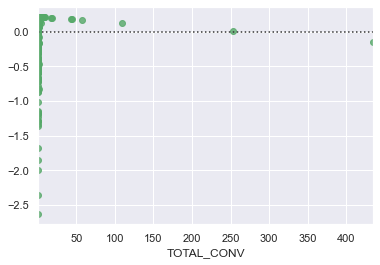

In [727]:
scale_transform_validate(data.iloc[:,:-1], data['TOTAL_CONV'], residuals=True)

# Bayesian Multiple Linear Regression

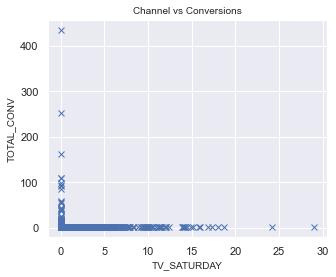

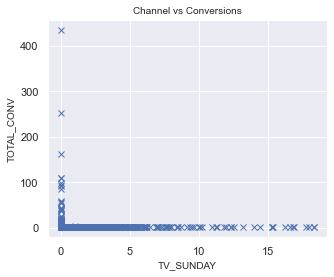

In [734]:
plot_relationship(data.iloc[:,-3:], 'TOTAL_CONV')

In [736]:
# model_formula = 'Conver = '
# for variable in normal_trace.varnames:
#     model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)
# ' '.join(model_formula.split(' ')[:-1])

## Building Multiple Bayesian Linear Model with pyMC3

In [5]:
x = data.iloc[:,:-1].values
y = data.TOTAL_CONV.values

In [6]:
with pm.Model() as model_mlr:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sd=10)
    
    # Slope
    beta = pm.Normal('beta', mu=0, sd =1, shape = len(data.columns[:-1]))
    
    # Error term
    eps = pm.HalfCauchy('eps', 5)
    
    # Expected value of outcome (MLR with vectors)
    mu = alpha + pm.math.dot(x, beta)
    
    # Likelihood
    conversion = pm.Normal('conversion', mu= mu, sd= eps, observed=y)
    
    # posterior
    trace = pm.sample(chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 101 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Convergency checks
In this model, we use ArviZ to check if our model has converged.

In [7]:
trace.varnames

['alpha', 'beta', 'eps_log__', 'eps']

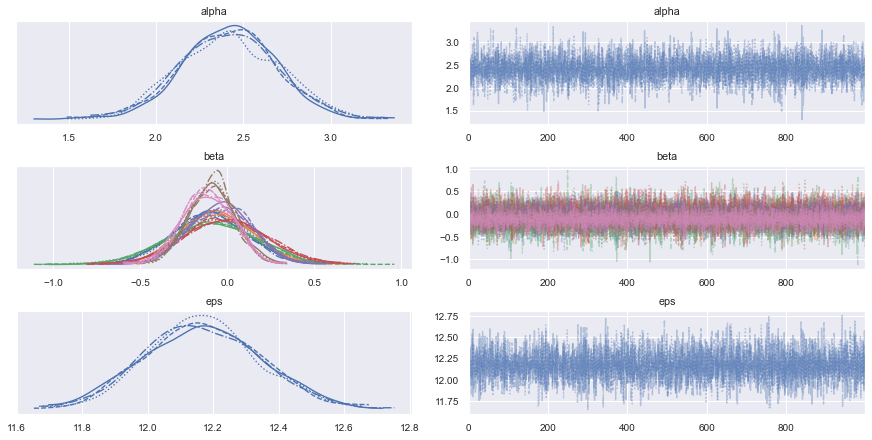

In [8]:
az.plot_trace(trace)
plt.show()

In [9]:
# Lets look at intercepts
varnames = ['alpha', 'eps', 'beta']
az.summary(trace, var_names = varnames[-1]).set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_MONDAY,-0.102,0.210,-0.516,0.270,0.003,0.003,6744.0,3369.0,1.0
TV_TUESDAY,-0.055,0.207,-0.459,0.325,0.002,0.003,6891.0,2814.0,1.0
TV_WEDNESDAY,-0.091,0.259,-0.567,0.393,0.003,0.004,6669.0,3125.0,1.0
TV_THURSDAY,-0.013,0.236,-0.469,0.411,0.003,0.004,7339.0,3103.0,1.0
TV_FRIDAY,-0.038,0.181,-0.362,0.300,0.002,0.003,6764.0,3016.0,1.0
TV_SATURDAY,-0.090,0.133,-0.353,0.152,0.002,0.002,7123.0,2849.0,1.0
TV_SUNDAY,-0.113,0.143,-0.376,0.151,0.002,0.002,7180.0,2886.0,1.0


In [10]:
# Lets look at the slope and error
az.summary(trace, var_names = varnames[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.417,0.278,1.919,2.956,0.003,0.002,7505.0,3009.0,1.0
eps,12.169,0.174,11.839,12.487,0.002,0.001,7354.0,2678.0,1.0


### Checking for correlation between slope and intercept

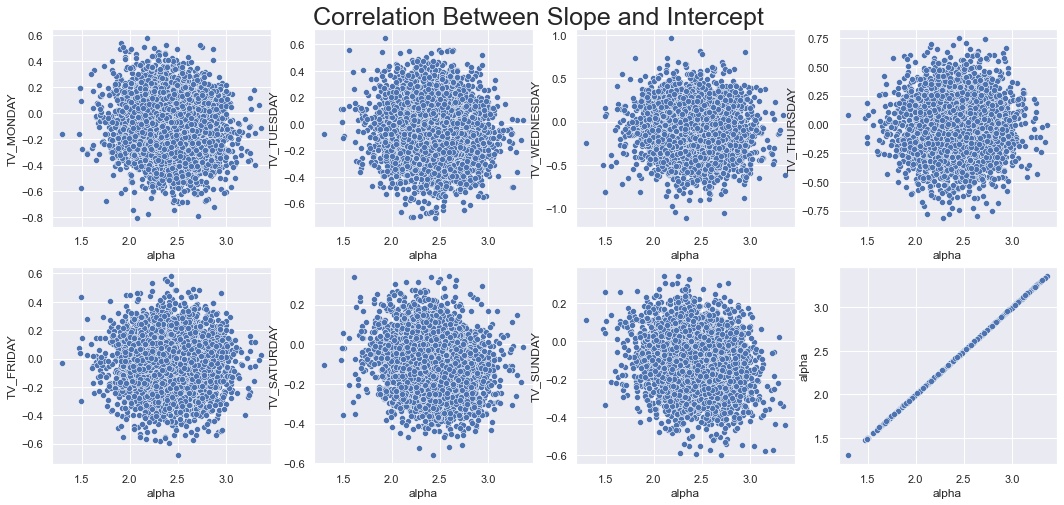

In [273]:
plot_correlation(trace, data)

In [133]:
# g = sns.PairGrid(df)
# g.map(sns.scatterplot)
# plt.show()

## Rhat statistic
The Rhat statistic measures how similar the different chains are. So to be able to compute it, we need at least two chains. If all chains converged to the same distribution, then the Rhat statistic should be close to 1.
An Rhat greater than 1.1 means something is very wrong and your model did not converge (in this case, PyMC3 will also raise some warnings). However, already a value above 1.01 is reason for concern, so when computing it via the summary function from ArviZ, it is best to deactive rounding.

The following parameters have an Rhat greater 1.01:


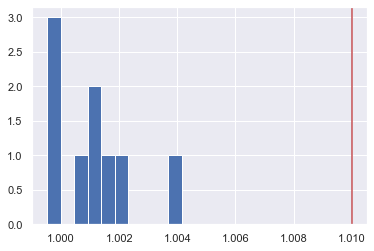

In [274]:
check_rhat(trace, 1.01)

#### Energy Distribution related to MCMC sampling that proposing different energy levels. We want our Margin plot be as wide as Energy plot. (They should be close to each other)

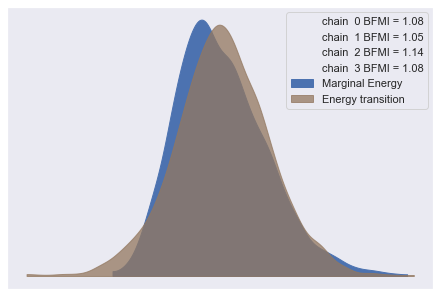

In [275]:
az.plot_energy(trace)
plt.show()

In [15]:
## Look for predictions using posterior

ppc = pm.sample_posterior_predictive(trace, samples=4000, model = model_mlr)

In [276]:
ppc['conversion'].astype(int)

array([[ -1,   0, -26, ...,  -1,   8,  -1],
       [-16,  -7,  -4, ...,  25,  14, -22],
       [  6,   6,  15, ...,  -6,  14,  -3],
       ...,
       [  4, -11,  -7, ...,   2,   8,  41],
       [  4,   9,   4, ...,   8,   2, -15],
       [ -1,  -5,  -9, ...,   8,   0,  -2]])

### As result of prediction we are getting Negative Conversions which is not sutisfy Buisness Idea

## Changing One Of the Priors (slope 'beta') to HalfNormal Distribution

In [281]:
with pm.Model() as model_mlr_halfnorm:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sd=10)
    
    # Slope
    beta = pm.HalfNormal('beta', sd =2, shape = len(data.columns[:-1]))
    
    # Error term
    eps = pm.HalfCauchy('eps', 5)
    
    # Expected value of outcome (ML Regression with vectors)
    mu = alpha + pm.math.dot(x, beta)
    #alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(x_mean, beta))
    
    # Likelihood
    conversion = pm.Normal('conversion', mu= mu, sd= eps, observed=y)
    
    # posterior
    trace_halfnorm = pm.sample(chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 165 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


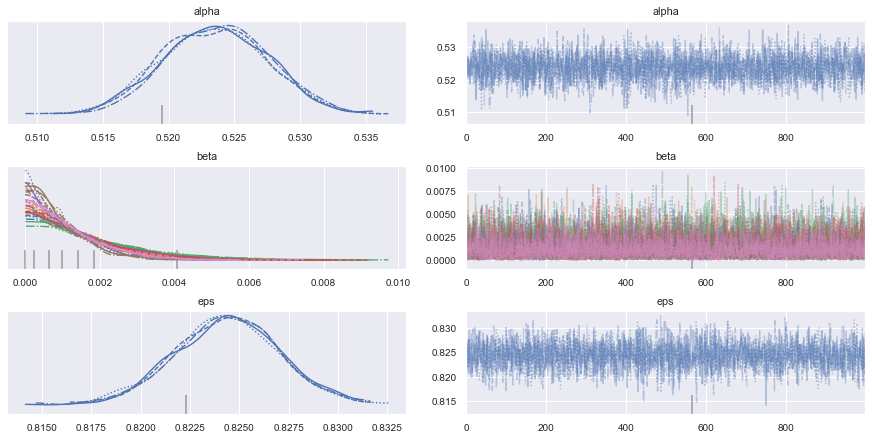

In [282]:
az.plot_trace(trace_halfnorm);

In [283]:
az.summary(trace_halfnorm, var_names = varnames[-1]).set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_MONDAY,0.002,0.001,0.0,0.004,0.0,0.0,1318.0,847.0,1.0
TV_TUESDAY,0.001,0.001,0.0,0.003,0.0,0.0,1838.0,935.0,1.0
TV_WEDNESDAY,0.002,0.001,0.0,0.004,0.0,0.0,1982.0,1367.0,1.0
TV_THURSDAY,0.001,0.001,0.0,0.004,0.0,0.0,1867.0,1200.0,1.0
TV_FRIDAY,0.001,0.001,0.0,0.003,0.0,0.0,1945.0,1261.0,1.0
TV_SATURDAY,0.001,0.001,0.0,0.002,0.0,0.0,2443.0,1471.0,1.0
TV_SUNDAY,0.001,0.001,0.0,0.003,0.0,0.0,2693.0,1716.0,1.0


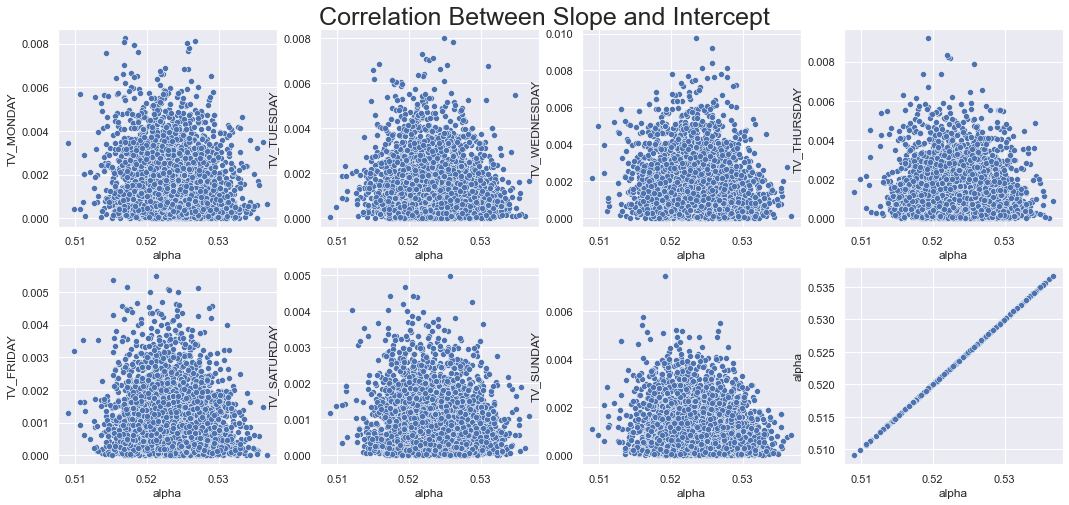

In [284]:
plot_correlation(trace_halfnorm,data)

In [286]:
#az.plot_forest(trace_halfnorm)

In [288]:
ppc_halfnorm = pm.sample_posterior_predictive(trace_halfnorm, samples=4000, model=model_mlr_halfnorm)

In [291]:
ppc_halfnorm['conversion'].astype(int)[0]

array([[0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 1]])

## Changing target distribution to InverseGamma Distribution

In [113]:
with pm.Model() as model_t:
        # Intercept
        alpha = pm.Normal('alpha', mu=2, sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd =5, shape = x.shape[1])
        # Error term
        eps = pm.HalfCauchy('eps', 5)
        #v = pm.Exponential('ν', 30)
        #ν = pm.Deterministic('ν', ν_ + 1)
        
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        #alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(x_mean, beta))

        # Likelihood
        conversion = pm.InverseGamma('conversion', 
                                 mu= mu,
                                 sigma= eps,
                                 alpha=6,
                                 beta=0.5,
                                 observed=y)
        # posterior
        trace_t = pm.sample(chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


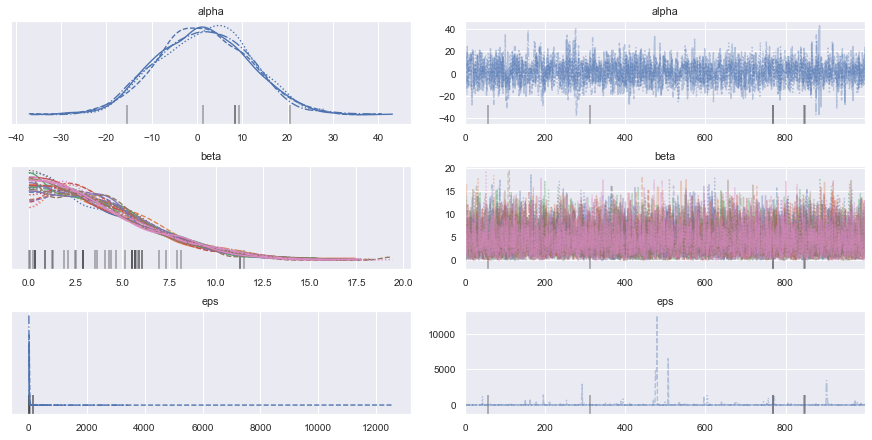

In [114]:
az.plot_trace(trace_t)
plt.show()

In [582]:
# Centering the independent variables in order to minimize correlation btw alpha and beta
# x_mean = x.mean(axis=0, keepdims=True)
# x_centered = x - x_mean 

### Changing Likelyhood function to LogNormal Distributionn 

In [6]:
with pm.Model() as model_mlr_log:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sd=10)
    
    # Slope
    beta = pm.HalfNormal('beta', sd =50, shape = len(data.columns[:-1]))
    
    # Error term
    eps = pm.HalfCauchy('eps', 5)
    
    # Expected value of outcome (ML Regression with vectors)
    mu = alpha + pm.math.dot(x, beta)
    #alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(x_mean, beta))
    
    # Likelihood
    conversion = pm.Lognormal('conversion', mu= mu, sigma= eps, observed=y)
    
    # posterior
    trace_log = pm.sample(chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [8]:
# Lets look at intercepts
varnames = ['alpha', 'eps', 'beta']
az.summary(trace_log, var_names = varnames[-1]).set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_MONDAY,0.002,0.002,0.0,0.006,0.0,0.0,2809.0,1917.0,1.0
TV_TUESDAY,0.002,0.002,0.0,0.006,0.0,0.0,2656.0,1652.0,1.0
TV_WEDNESDAY,0.002,0.002,0.0,0.006,0.0,0.0,3911.0,2460.0,1.0
TV_THURSDAY,0.002,0.002,0.0,0.006,0.0,0.0,3153.0,1409.0,1.0
TV_FRIDAY,0.002,0.002,0.0,0.005,0.0,0.0,2324.0,1155.0,1.0
TV_SATURDAY,0.001,0.001,0.0,0.003,0.0,0.0,3687.0,2105.0,1.0
TV_SUNDAY,0.001,0.001,0.0,0.004,0.0,0.0,2326.0,1529.0,1.0


In [10]:
az.summary(trace_log, var_names = varnames[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.163,0.012,0.143,0.185,0.0,0.0,3601.0,2461.0,1.0
eps,0.559,0.008,0.544,0.573,0.0,0.0,3647.0,2523.0,1.0


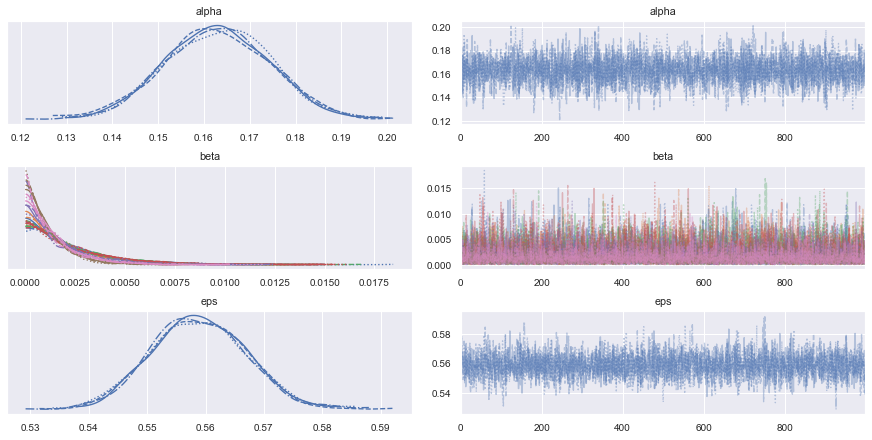

In [11]:
az.plot_trace(trace_log);

### Getting the posterior predictive samples  using the sample_posterior_predictive()

In [13]:
ppc_log = pm.sample_posterior_predictive(trace_log, samples=4000, model=model_mlr_log)

In [14]:
ppc_log['conversion'].astype(int)

array([[1, 1, 0, ..., 1, 4, 0],
       [1, 1, 0, ..., 1, 1, 0],
       [2, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 0, 1, ..., 1, 2, 0],
       [0, 2, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]])

In [47]:
# az.plot_forest(trace_log)

The following parameters have an Rhat greater 1.003:


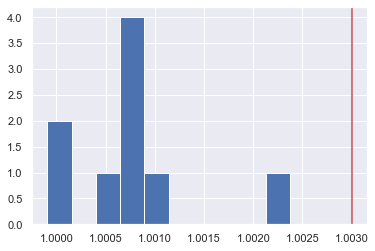

In [17]:
check_rhat(trace_log, 1.003)

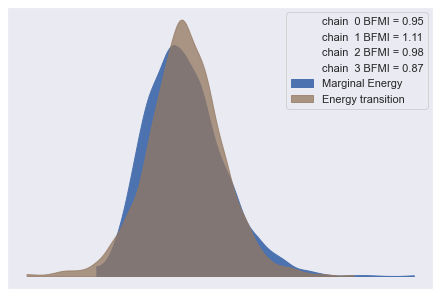

In [18]:
az.plot_energy(trace_log)
plt.show()

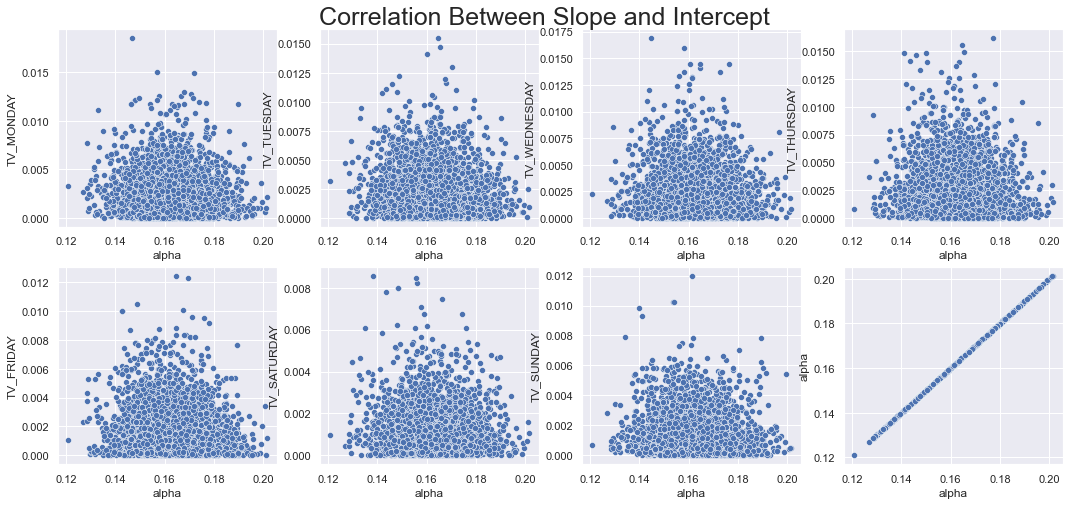

In [19]:
plot_correlation(trace_log, data)

### Analizing posterior predictive samples

In [53]:
ppc_log['conversion']

array([[1.13750607, 1.70761292, 0.79304346, ..., 1.5930431 , 4.64455247,
        0.6789223 ],
       [1.0196017 , 1.38974633, 0.65502722, ..., 1.08633173, 1.06826994,
        0.72394764],
       [2.8898711 , 1.05832183, 0.57322133, ..., 1.30298193, 0.88842437,
        1.42826086],
       ...,
       [1.97819583, 0.68743542, 1.48184553, ..., 1.23399009, 2.22647558,
        0.84552815],
       [0.84906482, 2.6017957 , 1.34434129, ..., 1.71994704, 1.16581563,
        1.14156148],
       [0.9388209 , 1.54249964, 1.38782631, ..., 1.77672729, 1.83201066,
        1.19909943]])

In [54]:
# Transpose index and columns in order to make each column as different sample
df_results = pd.DataFrame(np.round(ppc_log['conversion']).T.astype(int))
df_results.columns = ['sample_{}'.format(col) for col in df_results.columns]
df_results_col = df_results.columns

In [62]:
df_results.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_3990,sample_3991,sample_3992,sample_3993,sample_3994,sample_3995,sample_3996,sample_3997,sample_3998,sample_3999
0,1,1,3,2,1,1,1,1,1,2,...,1,2,2,1,1,1,1,2,1,1
1,2,1,1,2,2,1,1,2,1,0,...,2,1,1,1,1,1,1,1,3,2
2,1,1,1,1,2,1,1,0,1,1,...,3,2,2,2,3,2,2,1,1,1
3,2,3,0,4,1,1,1,2,3,1,...,1,1,0,1,1,1,4,1,1,1
4,1,2,4,1,2,1,3,1,2,1,...,1,1,2,2,1,1,2,3,1,1


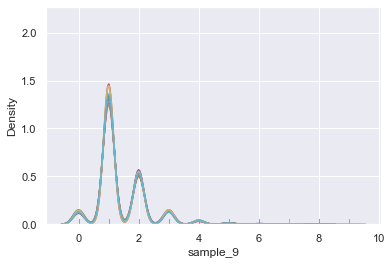

In [76]:
for col in df_results_col[:10]:
    sns.distplot(df_results[col], hist=False, rug=True)

In [ ]:
# model_formula = 'Conver = '
# for variable in normal_trace.varnames:
#     model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)
# ' '.join(model_formula.split(' ')[:-1])

In [79]:
trace_log

<MultiTrace: 4 chains, 1000 iterations, 5 variables>

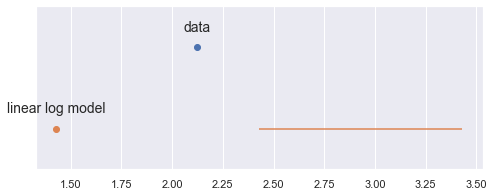

In [94]:
plt.figure(figsize=(8, 3))
data = [y, np.round(ppc_log['conversion'][0])]
labels = ['data', 'linear log model']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
    plt.ylim([-i-0.5, 0.5])
    plt.yticks([])